In [1]:
import numpy as np
from scipy.io import netcdf as nc
from matplotlib import pyplot as plt
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator

In [2]:
# Global grids area
nlon = 72
nlat = 45
grid_area = np.ones((nlat, nlon))*-9999.
earth_area = 5.096e14
lat = np.arange(-88, 92, 4)
res = 4;
for i in np.arange(0,nlat):
    for j in np.arange(0,nlon):
        grid_area[i,j] = (earth_area/2)*abs(np.sin((lat[i] - res/2)*np.pi/180) -
                    np.sin((lat[i] + res/2)*np.pi/180))/(360/res)

## Analysis of single site simulation

In [3]:
############################################################
### Pick a site for analysis
############################################################

## Inpyts from user
## Some constants
yr_beg = 1850
nyr_spinup = 5
nyr_transient = 5 

# grid area in m2
# This number shall be calculated for a given latitude and longitude
lon_pos = -55
lat_pos = -30

##  get and open the history file
##  change the line below to point to the file that you've made,
##  which should be a concatenation of a bunch of FATES history files into a single file
# filename_in_spinup = 'testluc.cori-haswell.E4f9ce69d2-F2d2a755c.2022-04-18.elm.h0.spinup.nc'
filename_in_spinup = 'SAPFT4_base.elm.h0.1850_1854.nc'
filename_in_transient = 'SAPFT4_base.elm.h0.1850_1854.nc'

## Do not modify the following
## Spinup history
# Monthly mean output
fin = nc.netcdf_file(filename_in_spinup)

## read the coordinate data for the various dimensions
## for both files they are the same so one-time read is good enough
time = (fin.variables['time'][:] - 1) / 365  ### time dimension, put in unit of years
patch_age_bins = fin.variables['fates_levage'][:]
cohort_size_bins = fin.variables['fates_levscls'][:]

## define the sizes of each dimension
ntim_spinup = len(time)
nagebins = len(patch_age_bins)
nsizebins = len(cohort_size_bins)

## read in variables
vegc_spinup = fin.variables['FATES_VEGC'][:]   # kgc m-2
vegc_pf_spinup = fin.variables['FATES_VEGC_PF'][:]   # kgc m-2
gpp_spinup = fin.variables['FATES_GPP'][:]   # kgc m-2 s-1
npp_spinup = fin.variables['FATES_NPP'][:]   # kgc m-2 s-1
biomass_pf_spinup = fin.variables['FATES_VEGC_PF'][:]  # kgc m-2 [SZxPFT]
area_ag_spinup = fin.variables['FATES_PATCHAREA_AP'][:]   # fraction
npatch_spinip = fin.variables['FATES_NPATCHES'][:]
ncohort_spinip = fin.variables['FATES_NCOHORTS'][:]
fin.close()

# ## Transient history
# # Daily output
# fin = nc.netcdf_file(filename_in_transient)

# ## read the coordinate data for the various dimensions
# time = (fin.variables['time'][:] - 1) / 365  ### time dimension, put in unit of years

# ## define the sizes of each dimension
# ntim_transient = len(time)

## read in variables
# vegc_transient = fin.variables['FATES_VEGC'][:]   # kgc m-2
# gpp_transient = fin.variables['FATES_GPP'][:]   # kgc m-2 s-1
# npp_transient = fin.variables['FATES_NPP'][:]   # kgc m-2 s-1
# biomass_szpf_transient = fin.variables['FATES_VEGC_SZPF'][:]  # kgc m-2 [SZxPFT]
# area_ag_transient = fin.variables['FATES_PATCHAREA_AP'][:]   # fraction
# hrv_flux10c_transient = fin.variables['HRV_DEADSTEMC_TO_PROD10C'][:]   # kgc m-2 s-1
# hrv_flux100c_transient = fin.variables['HRV_DEADSTEMC_TO_PROD100C'][:]   # kgc m-2 s-1
# hrv_10c_transient = fin.variables['PROD10C'][:]   # kgc m-2
# hrv_100c_transient = fin.variables['PROD100C'][:]   # kgc m-2
# fin.close()

## Auxiliary data: land use time series
filename_in_luinput = 'landuse.timeseries_1x1_brazil_hist_simyr1850-2015_c200310_biomass_harvest.nc' 
# One boreal site
# filename_in_luinput = 'landuse.timeseries_4x5_hist_simyr1850-2015.testluc_biomass_harvest.nc' 
fin_luinput = nc.netcdf_file(filename_in_luinput)
lu_hrv_frac = fin_luinput.variables['HARVEST_VH1_FRAC'][:]+fin_luinput.variables['HARVEST_VH2_FRAC'][:]
lu_hrv_c = fin_luinput.variables['HARVEST_VH1'][:]+fin_luinput.variables['HARVEST_VH2'][:]
fin_luinput.close()

# biomass_den = np.nanmean(biomass_wthrv, 1)
# biomass_den = np.nansum(biomass_wthrv*area_age_wthrv, 1)
# ## because the bin edges read in define the lower edges, add a last index to each to
# ## represent the upper edge of the distribution (even though there isn't one, really)
# patch_age_bins = np.append(patch_age_bins,patch_age_bins[nagebins-1]*1.5)
# cohort_size_bins = np.append(cohort_size_bins,cohort_size_bins[nsizebins-1]*1.5)

C:\Users\sshu3\Anaconda2\lib\site-packages\scipy\io\netcdf.py:317: RuntimeWarning: Cannot close a netcdf_file opened with mmap=True, when netcdf_variables or arrays referring to its data still exist. All data arrays obtained from such files refer directly to data on disk, and must be copied before the file can be cleanly closed. (See netcdf_file docstring for more information on mmap.)
  ), category=RuntimeWarning)


#### Sensitivity from certain parameters

In [5]:
############################################################
### Pick a site for analysis
############################################################

## Inpyts from user
## Some constants
yr_beg = 1850
nyr = 110

# grid area in m2
# This number shall be calculated for a given latitude and longitude
lon_pos = -150
lat_pos = 62

##  get and open the history file
# filename_in_spinup = 'testluc.cori-haswell.E4f9ce69d2-F2d2a755c.2022-04-18.elm.h0.spinup.nc'
filename_in_base_fixedbg = 'fates.NAPFT26.fixedbg.elm.h0.1850_1959.nc'
filename_in_base_nocomp = 'fates.NAPFT26.nocomp.elm.h0.1850_1959.nc'
filename_in_hvmax25_fixedbg = 'fates.NAPFT26.fixedbg_hvmax25.elm.h0.1850_1959.nc'
filename_in_hvmax25_nocomp = 'fates.NAPFT26.nocomp_hvmax25.elm.h0.1850_1926.nc'
filename_in_lvmaxha_fixedbg = 'fates.NAPFT26.fixedbg_lvmaxha.elm.h0.1850_1959.nc'
filename_in_lvmaxha_nocomp = 'fates.NAPFT26.nocomp_lvmaxha.elm.h0.1850_1926.nc'
filename_in_hsla_fixedbg = 'fates.NAPFT26.fixedbg_hsla.elm.h0.1850_1959.nc'
filename_in_hsla_nocomp = 'fates.NAPFT26.nocomp_hsla.elm.h0.1850_1959.nc'

## Do not modify the following
## Spinup history
# Monthly mean output
fin = nc.netcdf_file(filename_in_base_fixedbg)

## read the coordinate data for the various dimensions
## for both files they are the same so one-time read is good enough
time = (fin.variables['time'][:] - 1) / 365  ### time dimension, put in unit of years
patch_age_bins = fin.variables['fates_levage'][:]
cohort_size_bins = fin.variables['fates_levscls'][:]

## define the sizes of each dimension
ntim_spinup = len(time)
nagebins = len(patch_age_bins)
nsizebins = len(cohort_size_bins)

## read in variables
vegc_f1 = fin.variables['FATES_VEGC'][:]   # kgc m-2
vegc_pf_f1 = fin.variables['FATES_VEGC_PF'][:]   # kgc m-2
gpp_pf_f1 = fin.variables['FATES_GPP_PF'][:]   # kgc m-2 s-1
npp_pf_f1 = fin.variables['FATES_NPP_PF'][:]   # kgc m-2 s-1
area_ag_f1 = fin.variables['FATES_PATCHAREA_AP'][:]   # fraction
npatch_f1 = fin.variables['FATES_NPATCHES'][:]
ncohort_f1 = fin.variables['FATES_NCOHORTS'][:]
fin.close()

# Monthly mean output
fin = nc.netcdf_file(filename_in_base_nocomp)

## read in variables
vegc_n1 = fin.variables['FATES_VEGC'][:]   # kgc m-2
vegc_pf_n1 = fin.variables['FATES_VEGC_PF'][:]   # kgc m-2
gpp_pf_n1 = fin.variables['FATES_GPP_PF'][:]   # kgc m-2 s-1
npp_pf_n1 = fin.variables['FATES_NPP_PF'][:]   # kgc m-2 s-1
area_ag_n1 = fin.variables['FATES_PATCHAREA_AP'][:]   # fraction
npatch_n1 = fin.variables['FATES_NPATCHES'][:]
ncohort_n1 = fin.variables['FATES_NCOHORTS'][:]
fin.close()

# Monthly mean output
fin = nc.netcdf_file(filename_in_hvmax25_fixedbg)

## read in variables
vegc_f2 = fin.variables['FATES_VEGC'][:]   # kgc m-2
vegc_pf_f2 = fin.variables['FATES_VEGC_PF'][:]   # kgc m-2
gpp_pf_f2 = fin.variables['FATES_GPP_PF'][:]   # kgc m-2 s-1
npp_pf_f2 = fin.variables['FATES_NPP_PF'][:]   # kgc m-2 s-1
area_ag_f2 = fin.variables['FATES_PATCHAREA_AP'][:]   # fraction
npatch_f2 = fin.variables['FATES_NPATCHES'][:]
ncohort_f2 = fin.variables['FATES_NCOHORTS'][:]
fin.close()

# Monthly mean output
fin = nc.netcdf_file(filename_in_hvmax25_nocomp)

## read in variables
vegc_n2 = fin.variables['FATES_VEGC'][:]   # kgc m-2
vegc_pf_n2 = fin.variables['FATES_VEGC_PF'][:]   # kgc m-2
gpp_pf_n2 = fin.variables['FATES_GPP_PF'][:]   # kgc m-2 s-1
npp_pf_n2 = fin.variables['FATES_NPP_PF'][:]   # kgc m-2 s-1
area_ag_n2 = fin.variables['FATES_PATCHAREA_AP'][:]   # fraction
npatch_n2 = fin.variables['FATES_NPATCHES'][:]
ncohort_n2 = fin.variables['FATES_NCOHORTS'][:]
fin.close()

# Monthly mean output
fin = nc.netcdf_file(filename_in_lvmaxha_fixedbg)

## read the coordinate data for the various dimensions
## for both files they are the same so one-time read is good enough
time = (fin.variables['time'][:] - 1) / 365  ### time dimension, put in unit of years
patch_age_bins = fin.variables['fates_levage'][:]
cohort_size_bins = fin.variables['fates_levscls'][:]

## define the sizes of each dimension
ntim_spinup = len(time)
nagebins = len(patch_age_bins)
nsizebins = len(cohort_size_bins)

## read in variables
vegc_f3 = fin.variables['FATES_VEGC'][:]   # kgc m-2
vegc_pf_f3 = fin.variables['FATES_VEGC_PF'][:]   # kgc m-2
gpp_pf_f3 = fin.variables['FATES_GPP_PF'][:]   # kgc m-2 s-1
npp_pf_f3 = fin.variables['FATES_NPP_PF'][:]   # kgc m-2 s-1
area_ag_f3 = fin.variables['FATES_PATCHAREA_AP'][:]   # fraction
npatch_f3 = fin.variables['FATES_NPATCHES'][:]
ncohort_f3 = fin.variables['FATES_NCOHORTS'][:]
fin.close()

# Monthly mean output
fin = nc.netcdf_file(filename_in_lvmaxha_nocomp)

## read in variables
vegc_n3 = fin.variables['FATES_VEGC'][:]   # kgc m-2
vegc_pf_n3 = fin.variables['FATES_VEGC_PF'][:]   # kgc m-2
gpp_pf_n3 = fin.variables['FATES_GPP_PF'][:]   # kgc m-2 s-1
npp_pf_n3 = fin.variables['FATES_NPP_PF'][:]   # kgc m-2 s-1
area_ag_n3 = fin.variables['FATES_PATCHAREA_AP'][:]   # fraction
npatch_n3 = fin.variables['FATES_NPATCHES'][:]
ncohort_n3 = fin.variables['FATES_NCOHORTS'][:]
fin.close()

# Monthly mean output
fin = nc.netcdf_file(filename_in_hsla_fixedbg)

## read in variables
vegc_f4 = fin.variables['FATES_VEGC'][:]   # kgc m-2
vegc_pf_f4 = fin.variables['FATES_VEGC_PF'][:]   # kgc m-2
gpp_pf_f4 = fin.variables['FATES_GPP_PF'][:]   # kgc m-2 s-1
npp_pf_f4 = fin.variables['FATES_NPP_PF'][:]   # kgc m-2 s-1
area_ag_f4 = fin.variables['FATES_PATCHAREA_AP'][:]   # fraction
npatch_f4 = fin.variables['FATES_NPATCHES'][:]
ncohort_f4 = fin.variables['FATES_NCOHORTS'][:]
fin.close()

# Monthly mean output
fin = nc.netcdf_file(filename_in_hsla_nocomp)

## read in variables
vegc_n4 = fin.variables['FATES_VEGC'][:]   # kgc m-2
vegc_pf_n4 = fin.variables['FATES_VEGC_PF'][:]   # kgc m-2
gpp_pf_n4 = fin.variables['FATES_GPP_PF'][:]   # kgc m-2 s-1
npp_pf_n4 = fin.variables['FATES_NPP_PF'][:]   # kgc m-2 s-1
area_ag_n4 = fin.variables['FATES_PATCHAREA_AP'][:]   # fraction
npatch_n4 = fin.variables['FATES_NPATCHES'][:]
ncohort_n4 = fin.variables['FATES_NCOHORTS'][:]
fin.close()

## Auxiliary data: land use time series
filename_in_luinput = 'landuse.timeseries_1x1_brazil_hist_simyr1850-2015_c200310_biomass_harvest.nc' 
# One boreal site
# filename_in_luinput = 'landuse.timeseries_4x5_hist_simyr1850-2015.testluc_biomass_harvest.nc' 
fin_luinput = nc.netcdf_file(filename_in_luinput)
lu_hrv_frac = fin_luinput.variables['HARVEST_VH1_FRAC'][:]+fin_luinput.variables['HARVEST_VH2_FRAC'][:]
lu_hrv_c = fin_luinput.variables['HARVEST_VH1'][:]+fin_luinput.variables['HARVEST_VH2'][:]
fin_luinput.close()

# biomass_den = np.nanmean(biomass_wthrv, 1)
# biomass_den = np.nansum(biomass_wthrv*area_age_wthrv, 1)
# ## because the bin edges read in define the lower edges, add a last index to each to
# ## represent the upper edge of the distribution (even though there isn't one, really)
# patch_age_bins = np.append(patch_age_bins,patch_age_bins[nagebins-1]*1.5)
# cohort_size_bins = np.append(cohort_size_bins,cohort_size_bins[nsizebins-1]*1.5)

In [6]:
np.shape(gpp_pf_n3)

(924L, 12L, 1L)

Text(0.5,1,'Site NAPFT26 Productivities')

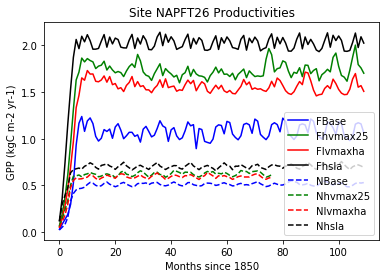

In [8]:
## Check productivity
gpp_yr_f1 = np.zeros((nyr))
gpp_yr_f2 = np.zeros((nyr))
gpp_yr_f3 = np.zeros((nyr))
gpp_yr_f4 = np.zeros((nyr))
gpp_yr_n1 = np.zeros((nyr))
gpp_yr_n2 = np.zeros((77))
gpp_yr_n3 = np.zeros((77))
gpp_yr_n4 = np.zeros((nyr))
for iyr in np.arange(0,nyr):
    id_beg = iyr*12
    id_end = (iyr+1)*12-1
    gpp_yr_f1[iyr] = np.nanmean(np.nansum(gpp_pf_f1[:,:,0], 1)[id_beg:id_end])*3600*24*365
    gpp_yr_f2[iyr] = np.nanmean(np.nansum(gpp_pf_f2[:,:,0], 1)[id_beg:id_end])*3600*24*365
    gpp_yr_f3[iyr] = np.nanmean(np.nansum(gpp_pf_f3[:,:,0], 1)[id_beg:id_end])*3600*24*365
    gpp_yr_f4[iyr] = np.nanmean(np.nansum(gpp_pf_f4[:,:,0], 1)[id_beg:id_end])*3600*24*365
    gpp_yr_n1[iyr] = np.nanmean(np.nansum(gpp_pf_n1[:,:,0], 1)[id_beg:id_end])*3600*24*365
    gpp_yr_n4[iyr] = np.nanmean(np.nansum(gpp_pf_n4[:,:,0], 1)[id_beg:id_end])*3600*24*365
    
for iyr in np.arange(0,77):
    id_beg = iyr*12
    id_end = (iyr+1)*12-1
    gpp_yr_n2[iyr] = np.nanmean(np.nansum(gpp_pf_n2[:,:,0], 1)[id_beg:id_end])*3600*24*365
    gpp_yr_n3[iyr] = np.nanmean(np.nansum(gpp_pf_n3[:,:,0], 1)[id_beg:id_end])*3600*24*365
    
plt.plot(gpp_yr_f1, 'b-')
plt.plot(gpp_yr_f2, 'g-')
plt.plot(gpp_yr_f3, 'r-')
plt.plot(gpp_yr_f4, 'k-')
plt.plot(gpp_yr_n1, 'b--')
plt.plot(gpp_yr_n2, 'g--')
plt.plot(gpp_yr_n3, 'r--')
plt.plot(gpp_yr_n4, 'k--')
plt.xlabel('Months since 1850')
plt.ylabel('GPP (kgC m-2 yr-1)')
plt.legend(['FBase', 'Fhvmax25', 'Flvmaxha', 'Fhsla', 'NBase', 'Nhvmax25', 'Nlvmaxha', 'Nhsla'])
plt.title('Site NAPFT26 Productivities')
# plt.savefig('validate_cbased_luc_frac.png')

Text(0.5,1,'Site NAPFT26 VegC')

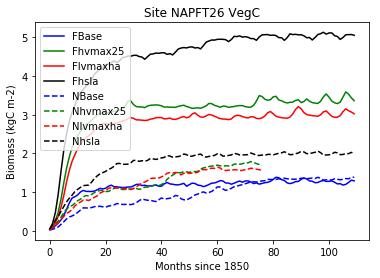

In [11]:
## Check biomass
vegc_yr_f1 = np.zeros((nyr))
vegc_yr_f2 = np.zeros((nyr))
vegc_yr_f3 = np.zeros((nyr))
vegc_yr_f4 = np.zeros((nyr))
vegc_yr_n1 = np.zeros((nyr))
vegc_yr_n2 = np.zeros((77))
vegc_yr_n3 = np.zeros((77))
vegc_yr_n4 = np.zeros((nyr))
for iyr in np.arange(0,nyr):
    id_beg = iyr*12
    id_end = (iyr+1)*12-1
    vegc_yr_f1[iyr] = np.nanmean(np.nansum(vegc_pf_f1[:,:,0], 1)[id_beg:id_end])
    vegc_yr_f2[iyr] = np.nanmean(np.nansum(vegc_pf_f2[:,:,0], 1)[id_beg:id_end])
    vegc_yr_f3[iyr] = np.nanmean(np.nansum(vegc_pf_f3[:,:,0], 1)[id_beg:id_end])
    vegc_yr_f4[iyr] = np.nanmean(np.nansum(vegc_pf_f4[:,:,0], 1)[id_beg:id_end])
    vegc_yr_n1[iyr] = np.nanmean(np.nansum(vegc_pf_n1[:,:,0], 1)[id_beg:id_end])
    vegc_yr_n4[iyr] = np.nanmean(np.nansum(vegc_pf_n4[:,:,0], 1)[id_beg:id_end])
    
for iyr in np.arange(0,77):
    id_beg = iyr*12
    id_end = (iyr+1)*12-1
    vegc_yr_n2[iyr] = np.nanmean(np.nansum(vegc_pf_n2[:,:,0], 1)[id_beg:id_end])
    vegc_yr_n3[iyr] = np.nanmean(np.nansum(vegc_pf_n3[:,:,0], 1)[id_beg:id_end])
    
plt.plot(vegc_yr_f1, 'b-')
plt.plot(vegc_yr_f2, 'g-')
plt.plot(vegc_yr_f3, 'r-')
plt.plot(vegc_yr_f4, 'k-')
plt.plot(vegc_yr_n1, 'b--')
plt.plot(vegc_yr_n2, 'g--')
plt.plot(vegc_yr_n3, 'r--')
plt.plot(vegc_yr_n4, 'k--')
plt.xlabel('Months since 1850')
plt.ylabel('Biomass (kgC m-2)')
plt.legend(['FBase', 'Fhvmax25', 'Flvmaxha', 'Fhsla', 'NBase', 'Nhvmax25', 'Nlvmaxha', 'Nhsla'])
plt.title('Site NAPFT26 VegC')
# plt.savefig('validate_cbased_luc_frac.png')

Text(0.5,1,'Site NAPFT26 VegC')

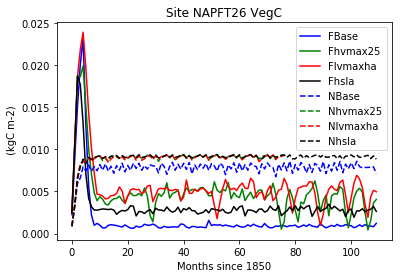

In [16]:
## Check results for specific PFTs
## Biomass for specified PFT
pid = 8
vegc_yr_f1 = np.zeros((nyr))
vegc_yr_f2 = np.zeros((nyr))
vegc_yr_f3 = np.zeros((nyr))
vegc_yr_f4 = np.zeros((nyr))
vegc_yr_n1 = np.zeros((nyr))
vegc_yr_n2 = np.zeros((77))
vegc_yr_n3 = np.zeros((77))
vegc_yr_n4 = np.zeros((nyr))
for iyr in np.arange(0,nyr):
    id_beg = iyr*12
    id_end = (iyr+1)*12-1
    vegc_yr_f1[iyr] = np.nanmean(vegc_pf_f1[id_beg:id_end,pid,0])
    vegc_yr_f2[iyr] = np.nanmean(vegc_pf_f2[id_beg:id_end,pid,0])
    vegc_yr_f3[iyr] = np.nanmean(vegc_pf_f3[id_beg:id_end,pid,0])
    vegc_yr_f4[iyr] = np.nanmean(vegc_pf_f4[id_beg:id_end,pid,0])
    vegc_yr_n1[iyr] = np.nanmean(vegc_pf_n1[id_beg:id_end,pid,0])
    vegc_yr_n4[iyr] = np.nanmean(vegc_pf_n4[id_beg:id_end,pid,0])
    
for iyr in np.arange(0,77):
    id_beg = iyr*12
    id_end = (iyr+1)*12-1
    vegc_yr_n2[iyr] = np.nanmean(vegc_pf_n2[id_beg:id_end,pid,0])
    vegc_yr_n3[iyr] = np.nanmean(vegc_pf_n3[id_beg:id_end,pid,0])
    
plt.plot(vegc_yr_f1, 'b-')
plt.plot(vegc_yr_f2, 'g-')
plt.plot(vegc_yr_f3, 'r-')
plt.plot(vegc_yr_f4, 'k-')
plt.plot(vegc_yr_n1, 'b--')
plt.plot(vegc_yr_n2, 'g--')
plt.plot(vegc_yr_n3, 'r--')
plt.plot(vegc_yr_n4, 'k--')
plt.xlabel('Months since 1850')
plt.ylabel(' (kgC m-2)')
plt.legend(['FBase', 'Fhvmax25', 'Flvmaxha', 'Fhsla', 'NBase', 'Nhvmax25', 'Nlvmaxha', 'Nhsla'])
plt.title('Site NAPFT26 VegC')
# plt.savefig('validate_cbased_luc_frac.png')


In [ ]:
## Validate biomass
# Annual mean, spinup
veg_c_pf1 = np.zeros((nyr_spinup*12))
veg_c_pf2 = np.zeros((nyr_spinup*12))
veg_c_pf3 = np.zeros((nyr_spinup*12))
veg_c_pf4 = np.zeros((nyr_spinup*12))
veg_c_pf5 = np.zeros((nyr_spinup*12))
veg_c_pf6 = np.zeros((nyr_spinup*12))
veg_c_pf7 = np.zeros((nyr_spinup*12))
veg_c_pf8 = np.zeros((nyr_spinup*12))
veg_c_pf9 = np.zeros((nyr_spinup*12))

for id in np.arange(0,nyr_spinup*12):
    veg_c_pf1[id] = vegc_pf_spinup[id, 0, 0]
    veg_c_pf2[id] = vegc_pf_spinup[id, 1, 0]
    veg_c_pf3[id] = vegc_pf_spinup[id, 2, 0]
    veg_c_pf4[id] = vegc_pf_spinup[id, 3, 0]
    veg_c_pf5[id] = vegc_pf_spinup[id, 4, 0]
    veg_c_pf6[id] = vegc_pf_spinup[id, 5, 0]
    veg_c_pf7[id] = vegc_pf_spinup[id, 6, 0]
    veg_c_pf8[id] = vegc_pf_spinup[id, 7, 0]
    veg_c_pf9[id] = vegc_pf_spinup[id, 8, 0]
    
plt.plot(veg_c_pf1)
plt.plot(veg_c_pf2)
plt.plot(veg_c_pf3)
plt.plot(veg_c_pf4)
plt.plot(veg_c_pf5)
plt.plot(veg_c_pf6)
plt.plot(veg_c_pf7)
plt.plot(veg_c_pf8)
plt.plot(veg_c_pf9)

# plt.plot(veg_c_mass_yr[58:58+nyr_transient], 'b-', linewidth=5)
# plt.plot(lu_hrv_c[0:nyr_transient,0,0], 'g--', linewidth=5)
plt.xlabel('Years since 1850')
plt.ylabel('Veg C (kgC m-2 yr-1)')
plt.legend(['PFT1', 'PFT2', 'PFT3', 'PFT4', 'PFT5', 'PFT6', 'PFT7', 'PFT8', 'PFT9'])
plt.title('Site XX Vegetation C from FATES')
# plt.savefig('validate_cbased_hrv_c.png')

In [ ]:
np.shape(vegc_pf_spinup)

In [ ]:
## Validate biomass from different PFTs
biomass_pf_yr = np.zeros((nyr_spinup, 2))
npatch_yr = np.zeros((nyr_spinup))
ncohort_yr = np.zeros((nyr_spinup))
for iyr in np.arange(0,nyr_spinup):
    id_beg = iyr*12
    id_end = (iyr+1)*12-1
    npatch_yr[iyr] = np.nanmean(npatch_spinip[id_beg:id_end])
    ncohort_yr[iyr] = np.nanmean(ncohort_spinip[id_beg:id_end])
    biomass_pf_yr[iyr,0] = np.nansum(np.nanmean(biomass_pf_spinup[id_beg:id_end,1,0], 0), 0)
    biomass_pf_yr[iyr,1] = np.nansum(np.nanmean(biomass_pf_spinup[id_beg:id_end,11,0], 0), 0)

# plt.plot(biomass_pf_yr[:,0], 'b-', linewidth=5)
# plt.plot(biomass_pf_yr[:,1], 'g--', linewidth=5)
plt.plot(ncohort_yr, 'b-', linewidth=5)
plt.plot(npatch_yr, 'g--', linewidth=5)
plt.xlabel('Years since 1850')
plt.ylabel('Number of cohorts/patches')
plt.legend(['cohorts', 'patches'])
# plt.ylabel('Veg C (kgC m-2 yr-1)')
# plt.legend(['Woody', 'Non-woody'])
plt.title('Site XX Vegetation C from FATES')

In [ ]:
hrv_pool_nohrv = hrv_flux10c_nohrv_elm + hrv_flux100c_nohrv_elm
hrv_pool_wthrv = hrv_flux10c_wthrv_elm + hrv_flux100c_wthrv_elm
plt.plot(hrv_c_nohrv, 'b-', linewidth=3)
plt.plot(hrv_c_wthrv, 'g--', linewidth=5)
plt.xlabel('Days since 2001-01-01')
plt.ylabel('Harvested C (gC m-2)')
plt.legend(['Spike', 'Uniform'])

In [ ]:
hrv_c_nohrv = hrv_10c_nohrv + hrv_100c_nohrv
hrv_c_wthrv = hrv_10c_wthrv + hrv_100c_wthrv
plt.plot(hrv_c_nohrv, 'b-', linewidth=3)
plt.plot(hrv_c_wthrv, 'g--', linewidth=5)
plt.xlabel('Days since 2001-01-01')
plt.ylabel('Harvested C in product pool(gC m-2)')
plt.legend(['Uniform', 'Spike'])
plt.savefig('comparison_uniform_vs_spike.png')

In [ ]:
# Check total biomass
plt.plot(biomass_den, 'g--', linewidth=5)
plt.xlabel('Days since 0001-01-01')
plt.ylabel('Biomass C (kgC m-2)')
plt.legend(['FATES'])
plt.title('Check total biomass')